In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

print("hej")

ModuleNotFoundError: No module named 'keras'

In [2]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
    print(df.head())
    intent = df["Intent"]
    unique_intent = list(set(intent))
    sentences = list(df["Sentence"])
  
    return (intent, unique_intent, sentences)
  


In [3]:
intent, unique_intent, sentences = load_dataset("data.csv")

                      Sentence Intent
0          What does that cost  price
1  What's the price of <Item>?  price
2          How much is <item>?  price
3              Cost of <Item>?  price
4       What does <Item> cost?  price


In [4]:
print(sentences[:5])

['What does that cost', "What's the price of <Item>?", 'How much is <item>?', 'Cost of <Item>?', 'What does <Item> cost?']


In [39]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/axelalvarsson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/axelalvarsson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
#define stemmer
stemmer = LancasterStemmer()

In [41]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [42]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  
  


42
[['what', 'does', 'that', 'cost'], ['what', 's', 'the', 'price', 'of', 'item']]


In [43]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    print(token)
    return token

In [44]:
def max_length(words):
    return(len(max(words, key = len)))
  

In [45]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 47 and Maximum length = 6


In [46]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [47]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
#print(encoded_doc)

In [48]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [49]:
padded_doc = padding_doc(encoded_doc, max_length)

In [50]:
padded_doc[:5]

array([[ 3, 18, 29, 10,  0,  0],
       [ 3, 30, 31, 19,  5,  1],
       [11, 20, 32,  1,  0,  0],
       [10,  5,  1,  0,  0,  0],
       [ 3, 18,  1, 10,  0,  0]], dtype=int32)

In [51]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (42, 6)


In [52]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [53]:
output_tokenizer.word_index

{'balance': 1, 'order': 2, 'price': 3, 'common': 4}

In [54]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [55]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [56]:
encoded_output.shape

(42, 1)

In [57]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [58]:
output_one_hot = one_hot(encoded_output)

/Users/axelalvarsson/opt/anaconda3/envs/nnlm/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [59]:
output_one_hot.shape

(42, 4)

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)


In [62]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (33, 6) and train_Y = (33, 4)
Shape of val_X = (9, 6) and val_Y = (9, 4)


In [63]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
  
    return model





In [64]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 6, 128)            6016      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total params: 277,540
Trainable params: 271,524
Non-trainable params: 6,016
_________________________________________________________________


In [65]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 33 samples, validate on 9 samples
Epoch 1/100
33/33 [==============================] - 4s 124ms/step - loss: 1.3826 - accuracy: 0.3636 - val_loss: 1.3821 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 1.38212, saving model to model.h5
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 1.3736 - accuracy: 0.5152 - val_loss: 1.3788 - val_accuracy: 0.4444

Epoch 00002: val_loss improved from 1.38212 to 1.37877, saving model to model.h5
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.3718 - accuracy: 0.4848 - val_loss: 1.3803 - val_accuracy: 0.2222

Epoch 00003: val_loss did not improve from 1.37877
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 1.3612 - accuracy: 0.3636 - val_loss: 1.3872 - val_accuracy: 0.2222

Epoch 00004: val_loss did not improve from 1.37877
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 1.3506 - accuracy: 0.3636 - val_loss: 1.3976 - val_acc

33/33 [==============================] - 0s 6ms/step - loss: 0.9222 - accuracy: 0.5455 - val_loss: 1.0762 - val_accuracy: 0.4444

Epoch 00039: val_loss improved from 1.10521 to 1.07616, saving model to model.h5
Epoch 40/100
33/33 [==============================] - 0s 5ms/step - loss: 0.8370 - accuracy: 0.6061 - val_loss: 1.0566 - val_accuracy: 0.4444

Epoch 00040: val_loss improved from 1.07616 to 1.05663, saving model to model.h5
Epoch 41/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8233 - accuracy: 0.6364 - val_loss: 1.0421 - val_accuracy: 0.4444

Epoch 00041: val_loss improved from 1.05663 to 1.04209, saving model to model.h5
Epoch 42/100
33/33 [==============================] - 0s 5ms/step - loss: 0.8232 - accuracy: 0.6364 - val_loss: 1.0219 - val_accuracy: 0.4444

Epoch 00042: val_loss improved from 1.04209 to 1.02193, saving model to model.h5
Epoch 43/100
33/33 [==============================] - 0s 3ms/step - loss: 0.7548 - accuracy: 0.6667 - val_loss: 0.995

33/33 [==============================] - 0s 4ms/step - loss: 0.2618 - accuracy: 0.9091 - val_loss: 0.6327 - val_accuracy: 0.7778

Epoch 00078: val_loss did not improve from 0.59923
Epoch 79/100
33/33 [==============================] - 0s 6ms/step - loss: 0.2136 - accuracy: 0.9394 - val_loss: 0.7029 - val_accuracy: 0.6667

Epoch 00079: val_loss did not improve from 0.59923
Epoch 80/100
33/33 [==============================] - 0s 4ms/step - loss: 0.2582 - accuracy: 0.9091 - val_loss: 0.8546 - val_accuracy: 0.6667

Epoch 00080: val_loss did not improve from 0.59923
Epoch 81/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2471 - accuracy: 0.9091 - val_loss: 1.0293 - val_accuracy: 0.4444

Epoch 00081: val_loss did not improve from 0.59923
Epoch 82/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.8485 - val_loss: 1.1262 - val_accuracy: 0.4444

Epoch 00082: val_loss did not improve from 0.59923
Epoch 83/100
33/33 [=======================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


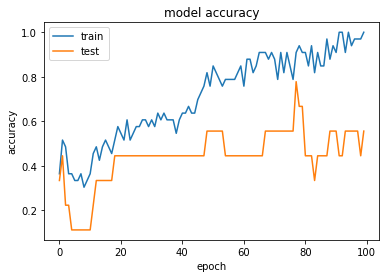

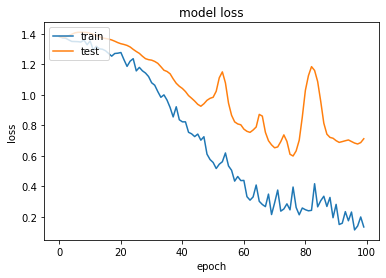

In [66]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
 model = load_model("model.h5")

In [68]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    print(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict_proba(x)
  
  
    return pred


  

In [69]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
 
    for i in range(pred.shape[1]):
        print("%s has confidence = %s" % (classes[i], (predictions[i])))



In [70]:
text = "How much does it cost?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'much', 'does', 'it', 'cost']
common has confidence = 0.55325747
price has confidence = 0.34460673
balance has confidence = 0.10033676
order has confidence = 0.001799061


In [71]:
opening_lines = ['Hello, what can I help you with?',
                'How can I help you?',
                'Whats on your mind today?']

def randomOpening():
    index = random.randint(0,len(opening_lines)-1)
    print(opening_lines[index])



In [72]:
def cli():
    while True:
        randomOpening()
        user_input = input("Ask the chatbot something: ")
        print(user_input)
        if(user_input=="quit"):
            break
        else:
            pred = predictions(user_input)
            print(pred)
            get_final_output(pred, unique_intent)

        
cli()

Hello, what can I help you with?
Ask the chatbot something: I want to buy a book.
I want to buy a book.
['i', 'want', 'to', 'buy', 'a', 'book']
[[0.09210964 0.00136301 0.3473941  0.5591333 ]]
common has confidence = 0.5591333
price has confidence = 0.3473941
balance has confidence = 0.09210964
order has confidence = 0.001363005
Whats on your mind today?
Ask the chatbot something: I want a lower price on this book.
I want a lower price on this book.
['i', 'want', 'a', 'lower', 'price', 'on', 'this', 'book']
[[1.71301626e-02 2.40766385e-04 1.00293934e-01 8.82335126e-01]]
common has confidence = 0.8823351
price has confidence = 0.100293934
balance has confidence = 0.017130163
order has confidence = 0.00024076639
Hello, what can I help you with?
Ask the chatbot something: My account balance is low.
My account balance is low.
['my', 'account', 'balance', 'is', 'low']
[[0.52638155 0.00786256 0.44779253 0.01796341]]
balance has confidence = 0.52638155
price has confidence = 0.44779253
common 

KeyboardInterrupt: Interrupted by user